In [1]:
# Import packages
import pandas as pd
import numpy as np

# For MCMC sampling
import pymc as pm
import arviz as az # Visualising mcmc sampling


# For wasserstein distance 
import ot # Can't get this one to work
import scipy.stats as stats 

from scipy.special import logsumexp

# For theme and plotting
import seaborn as sns 
import matplotlib.pyplot as plt

# To change string to latex for plots
from sympy import Symbol, latex 
# To get run time
import time 

import pytensor

# To perform kmeans
from sklearn.cluster import KMeans

sns.set_palette('Dark2')

# Init random seed
RANDOM_SEED = 307
rng = np.random.default_rng(RANDOM_SEED)

In [ ]:
# If wishing to reproduce exact results from report please load the following files

# Samples from original model
samples_1 = np.loadtxt("data/gaussian/samples_1.txt", delimiter=",")
# Samples from alpha = 100
samples_2 = np.loadtxt("data/gaussian/samples_2.txt", delimiter=",")

# Post-processed IR
samples_IR = np.loadtxt("data/gaussian/samples_IR.txt", delimiter=",")

# Post-processed AIS
samples_ais = np.loadtxt("data/gaussian/samples_ais.txt", delimiter=",")

# Samples from short MCMC
samples_2_ws = np.loadtxt("data/gaussian/samples_2_ws.txt", delimiter=",")
# Post-processed WS
samples_2_ws_init = np.loadtxt("data/gaussian/samples_2_ws_init.txt", delimiter=",")

# Samples from model with alpha = 5
samples_2_m = np.loadtxt("data/gaussian/samples_2_m.txt", delimiter=",")

# Post-processed IR
samples_IR_m = np.loadtxt("data/gaussian/samples_IR_m.txt", delimiter=",")

# Post-processed AIS
samples_ais_m = np.loadtxt("data/gaussian/samples_ais_m.txt", delimiter=",")

# Samples from short MCMC
samples_2_ws_m_init = np.loadtxt("data/gaussian/samples_2_ws_m_init.txt", delimiter=",")
# # Post-processed WS
samples_2_ws_m = np.loadtxt("data/gaussian/samples_2_ws_m.txt", delimiter=",")


In [3]:
def gen_data(sigma = 1, n = 100):
# Function to generate data from the given model
# sigma2 inv gamma prior and 
# y ~ Normal(X, sigma2)

    # Is it possible to have n X values?
    #X = np.random.randn(n) 
    #X = np.random.randn(1)
    X = 5
    np.random.seed(307)
    Y = np.random.normal(size = n, loc = X, scale = sigma)
    
    return X, Y

In [4]:
X, Y = gen_data(sigma = np.sqrt(0.25), n = 100)

In [32]:
# Functions for importance reweighting
def multinomial_resampling_IS(samples, log_weights):
# Function to perform multinomial resampling on given log-posterior functions and weights
# returning the regenerated samples.
    
    start_time = time.time()
    
    # Check if nan values in posterior probabilities
    if np.isnan(log_weights).any():
        print('Weights contains nan-values')
        return np.nan
    
    # Normalise with log sum exp trick
    weights_norm = np.exp(log_weights - logsumexp(log_weights))
    #weights_norm = weights/(np.sum(weights))
    # Make sure they are properly normalised
    weights_norm = weights_norm/(np.sum(weights_norm))

    # Check if nan values in normalised posterior probabilities
    if np.isnan(weights_norm).any():
        print('Normalise posterior probability contains nan-values')
        return np.nan, np.nan

    # Resample chain with posterior probabilities
    N = np.size(samples)
    I = np.random.choice(np.arange(N), size = N, replace = True, p = weights_norm)

    # Perform multinomial resampling 
    regenerated_samples = samples[I]

    run_time = time.time() - start_time 

    return regenerated_samples, run_time

def log_p(log_posterior, s, rv):

    return log_posterior({rv: s})

def post_processing(proposal_logp, target_logp, samples, rv):

    logp_vec = np.vectorize(log_p, excluded=(2,3))

    log_weight = logp_vec(target_logp, samples, rv) - logp_vec(proposal_logp, samples, rv) 

    return log_weight

In [141]:
# Functions for AIS


def f_j(f_0, f_n, x, beta, rv, n_var = 1):
    # Intermediate distribution on log scale
    
    # Allows for more than one variable input
    if n_var != 1:
      func_input = dict(zip(rv, x))
      result = f_0(func_input)*(beta) + f_n(func_input)*(1-beta)
      return result
    #result = f_0({rv: x})*(beta) + f_n({rv: x})*(1-beta)

    #return result
    return f_0({rv: x})*(beta) + f_n({rv: x})*(1-beta)

def T(x, f, step_size = 0.1, n_steps = 10, n_unknown = 1):
    # MCMC transition step with Random Walk
    count = 0
    
    for t in range(n_steps):
        # Proposal
        if n_unknown == 1:
            x_prime = x + np.random.normal(scale = step_size)
        else:
            x_prime = x + np.random.normal(scale = step_size, size = n_unknown)
    
        # Acceptance prob
        # in log scale
        a = f(x_prime) - f(x)
        #print('accept prob: ', a)
        # in log scale
        if np.log(np.random.rand()) < a:
            x = x_prime
            count += 1

    # For monitoring acceptance ratio   
    #print('Acceptance ratio:', count/n_steps)
    #print('Accepted samples:', count)

    return x

def multinomial_resampling(samples, log_weights):
# Function to perform multinomial resampling on given samples and weights
# returning the regenerated samples.
    
    # Check if nan values in posterior probabilities
    if np.isnan(log_weights).any():
        print('Weights contains nan-values')
        return np.nan
    
    # Normalise with log sum exp trick
    weights_norm = np.exp(log_weights - logsumexp(log_weights))
    #weights_norm = weights/(np.sum(weights))
    # Make sure they are properly normalised
    weights_norm = weights_norm/(np.sum(weights_norm))

    # Check if nan values in normalised posterior probabilities
    if np.isnan(weights_norm).any():
        print('Normalise posterior probability contains nan-values')
        return np.nan, np.nan
    #print(np.sum(weights_norm))
    # Resample chain with posterior probabilities
    N = np.size(samples)
    I = np.random.choice(np.arange(N), size = N, replace = True, p = weights_norm)

    # Perform multinomial resampling 
    regenerated_samples = samples[I]

    return regenerated_samples

def simulated_annealing(x, f_0, f_n, n_beta, n_T, n_var, rv, rv_step_size = 1):
    betas = np.linspace(0, 1, n_beta)
    w = 1
    global run_time_counter_inter 
    global run_time_counter
    #print('in simulated_annealing: ', rv)
    start_time = time.time()
    for n in range(1, len(betas)):
        start_time_inter = time.time()
        # Transition step
        #print(x)
        x = T(x, lambda y: f_j(f_0, f_n, y, betas[n], rv), step_size = rv_step_size, n_steps = n_T, n_unknown=n_var)

        # Compute weight in log space (log-sum):
        w += (f_j(f_0, f_n, x, betas[n], rv) - f_j(f_0, f_n, x, betas[n-1], rv))
        run_time_inter = time.time() - start_time_inter

        run_time_counter_inter += run_time_inter
    run_time = time.time() - start_time 

    run_time_counter += run_time
    return x, w

def ais(origin_samples, f_0, f_n, rv, n_T = 5, betas = None, n_beta = 10, rv_step_size = 1, n_variables = 1):
    start_time = time.time()

    if betas == None:
    # If no predefined beta inputted, define as a 
        betas = np.linspace(0, 1, n_beta)

    # Sampling & initialise
    n_samples = np.shape(origin_samples)[0] # number of samples post-process
    if np.shape(np.shape(origin_samples))[0] == 2:
        n_variables = np.shape(origin_samples)[1]
        samples = np.zeros((n_samples, n_variables))
    else:
        n_variables = 1
        samples = np.zeros(n_samples)

    log_weights = np.zeros(n_samples)

    # Do simulated annealing

    # Timer for each annealing run for each particle
    global run_time_counter
    run_time_counter = 0

    # Timer for each MCMC run for each annealing run for each particle
    global run_time_counter_inter 
    run_time_counter_inter = 0
    #print('In ais:', rv)
    #simulated_annealing_vec = np.vectorize(simulated_annealing)
    simulated_annealing_vec = np.vectorize(simulated_annealing, excluded = (6, 7))
    samples, log_weights = simulated_annealing_vec(origin_samples, f_0, f_n, n_beta, n_T, n_variables, rv, rv_step_size)
    # Perform multinomial resampling to obtain final regenerated samples
    regenerated_samples = multinomial_resampling(samples, log_weights)

    run_time = time.time() - start_time 
    print('Run time:', run_time)
    #print(np.var(log_weights))

    log_weight_var = np.var(log_weights)

    return samples, regenerated_samples, run_time, log_weight_var

In [34]:
# Function to plot

def density_plots(samples_1, samples_2, regenerated_samples, rv):
# Function which takes in model 1 and model 2 samples and the regenerated samples
# and returns the axes for a figure with all correpsonding estimated posterior distributions.

    ax = plt.gca()
    # Make x label to greek symbol for latex
    # Create symbolic variable from string
    x_label = Symbol(rv)
    
    # Plot density for model 1 and 2 samples
    # with the regenerated sample density 
    sns.kdeplot(samples_1, label = r'$\mathcal{M}_1$: MCMC samples', ax = ax)
    sns.kdeplot(samples_2, label = r'$\mathcal{M}_2$: MCMC samples', ax = ax)
    sns.kdeplot(regenerated_samples, label = 'Post-processed samples', ax = ax)

    # Remove top and right lines
    ax.spines['right'].set_visible(False) 
    ax.spines['top'].set_visible(False)

    # Latex to convert to latex string representation
    ax.set_xlabel(f'${latex(x_label)}$')
    ax.legend()

    return ax 

Original and $\alpha = 100$ updated model. 

In [5]:
with pm.Model() as model_1:
            
    mu = pm.Normal('mu', mu = 0, sigma = np.sqrt(1))

    Y_obs = pm.Normal('Observations Y', mu = mu, sigma = np.sqrt(0.25), observed = Y)

    idata_1 = pm.sample(chains = 4, draws = 2500, return_inferencedata = False)
    # Proposal distribution
    f_n = model_1.compile_logp()

samples_1 = idata_1.get_values('mu')

start_time = time.time()

with pm.Model() as model_2:
            
    mu = pm.Normal('mu', mu = 100, sigma = np.sqrt(1))

    Y_obs = pm.Normal('Observations Y', mu = mu, sigma = np.sqrt(0.25), observed = Y)

    idata_2 = pm.sample(chains = 4, draws = 2500, return_inferencedata = False)

run_time = time.time() - start_time
print(run_time)

with model_2:
    f_0 = model_2.compile_logp()

samples_2 = idata_2.get_values('mu')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 25 seconds.


30.404240131378174


In [169]:
np.savetxt("data/gaussian/samples_1.txt", samples_1, delimiter=",")
np.savetxt("data/gaussian/samples_2.txt", samples_2, delimiter=",")

Importance resampling

0.45192623138427734


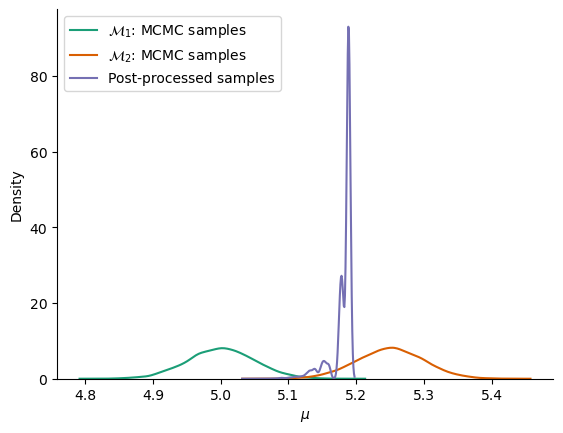

0.06986604830923877
0.17950460454439987


In [36]:
start_time = time.time()
log_weight_IR = post_processing(f_n, f_0, samples_1, 'mu')
samples_IR, _ = multinomial_resampling_IS(samples_1, log_weight_IR)
print(time.time() - start_time)

density_plots(samples_1, samples_2, samples_IR, 'mu')
#plt.savefig('examples/gaussian/IR_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(samples_2, samples_IR))
print(stats.wasserstein_distance(samples_1, samples_IR))

In [168]:
np.savetxt("data/gaussian/samples_IR.txt", samples_IR, delimiter=",")

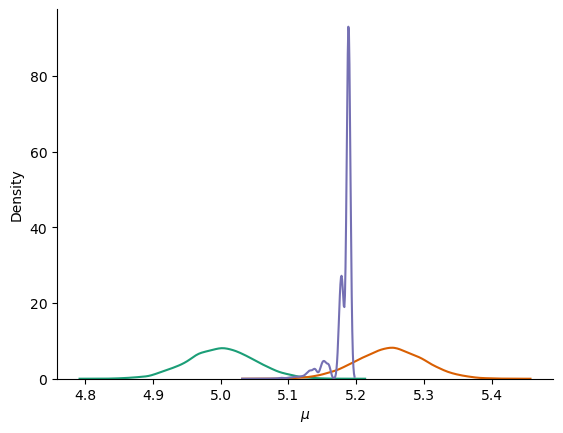

In [41]:
density_plots(samples_1, samples_2, samples_IR, 'mu')
plt.gca().get_legend().remove()
#plt.savefig('examples/gaussian/IR_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

In [42]:
print(np.mean(samples_2))
print(np.var(samples_2))
print(np.mean(samples_IR))
print(np.var(samples_IR))

5.25002255804459
0.002464382625814438
5.180156509735351
0.0002796369895404617


Next we do Annealed importance sampling

In [47]:
# Dont rerun
samples_pp, samples_ais, run_time, log_weight_variance = ais(origin_samples = samples_1, f_0 = f_0, f_n = f_n,
rv = 'mu', n_T = 5, n_beta = 15, rv_step_size = 0.1)

Run time: 68.05637407302856


In [171]:
np.savetxt("data/gaussian/samples_ais.txt", samples_ais, delimiter=",")

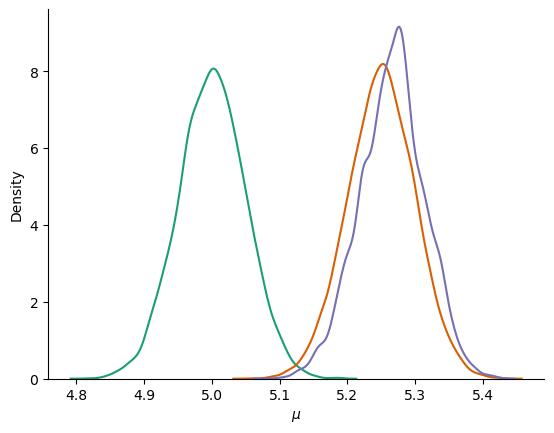

68.05637407302856
0.015559189022434573
0.2649267746155774


In [49]:
density_plots(samples_1, samples_2, samples_ais, 'mu')
plt.gca().get_legend().remove()
#plt.savefig('examples/gaussian/AIS_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()


print(run_time)
print(stats.wasserstein_distance(samples_2, samples_ais))
print(stats.wasserstein_distance(samples_1, samples_ais))

In [123]:
print(np.mean(samples_2))
print(np.var(samples_2))
print(np.mean(samples_ais))
print(np.var(samples_ais))

5.25002255804459
0.002464382625814438
5.265578679806529
0.0023057502979665105


Last we have warmstart mcmc

In [50]:
kmeans = KMeans(n_clusters = 4, random_state = 307)

kmeans.fit(np.array(samples_1).reshape(-1, 1))
init_values = kmeans.cluster_centers_.squeeze()

init_dict = [{'mu': init} for init in init_values]

/Users/ingahuldarmann/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Without initial conditions (short MCMC)

In [51]:
with model_2:
    idata_warmstart = pm.sample(chains = 4, draws = 100, return_inferencedata = True, tune = 50)

samples_2_ws = idata_warmstart.posterior.stack(draws=("chain", "draw"))['mu']
az.summary(idata_warmstart)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 27 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.256,0.047,5.18,5.357,0.004,0.003,128.0,162.0,1.02


0.006346805922202289
0.2555689582607075


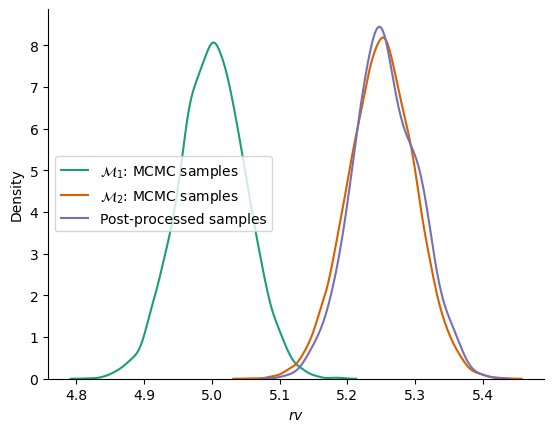

In [52]:
density_plots(samples_1, samples_2, samples_2_ws, 'rv')
print(stats.wasserstein_distance(samples_2, samples_2_ws))
print(stats.wasserstein_distance(samples_1, samples_2_ws))

With initial conditions (warm-start MCMC)

In [53]:
with model_2:
    idata_warmstart_init = pm.sample(chains = 4, draws = 100, return_inferencedata = True, initvals = init_dict, tune = 50)

samples_2_ws_init = idata_warmstart_init.posterior.stack(draws=("chain", "draw"))['mu']
az.summary(idata_warmstart_init)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.248,0.049,5.157,5.34,0.004,0.003,143.0,229.0,1.03


In [167]:
np.savetxt("data/gaussian/samples_2_ws.txt", samples_2_ws, delimiter=",")
np.savetxt("data/gaussian/samples_2_ws_init.txt", samples_2_ws_init, delimiter=",")

0.0033510742178952772
0.24689272343824525


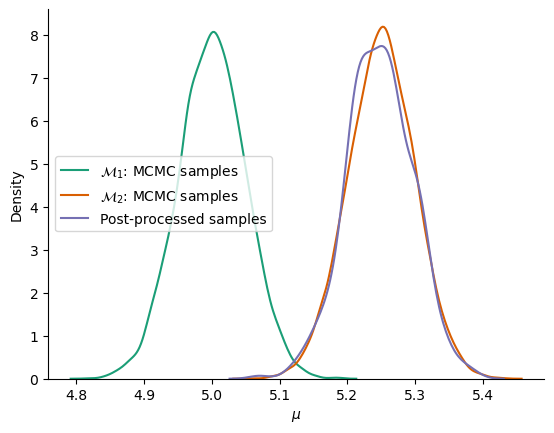

In [54]:
density_plots(samples_1, samples_2, samples_2_ws_init, 'mu')
print(stats.wasserstein_distance(samples_2, samples_2_ws_init))
print(stats.wasserstein_distance(samples_1, samples_2_ws_init))

In [55]:
print(np.mean(samples_2))
print(np.var(samples_2))
print(np.mean(samples_2_ws))
print(np.var(samples_2_ws))
print(np.mean(samples_2_ws_init))
print(np.var(samples_2_ws_init))

5.25002255804459
0.002464382625814438
<xarray.DataArray 'mu' ()>
array(5.25622086)
<xarray.DataArray 'mu' ()>
array(0.00223316)
<xarray.DataArray 'mu' ()>
array(5.24754463)
<xarray.DataArray 'mu' ()>
array(0.00235127)


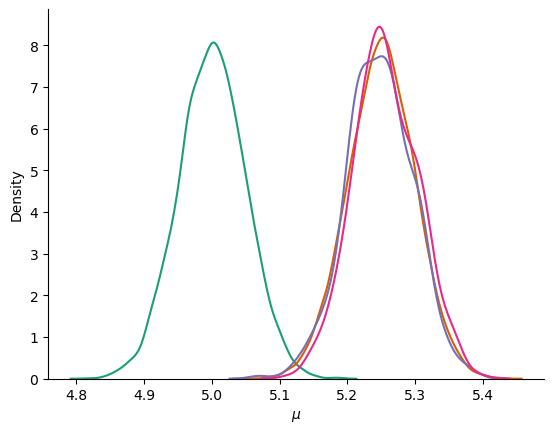

In [163]:
ax = plt.gca()
    # Make x label to greek symbol for latex
    # Create symbolic variable from string
x_label = Symbol('mu')
    
    # Plot density for model 1 and 2 samples
    # with the regenerated sample density 
sns.kdeplot(samples_1, label = r'$\mathcal{M}_1$: MCMC samples', ax = ax)
sns.kdeplot(samples_2, label = r'$\mathcal{M}_2$: MCMC samples', ax = ax)
sns.kdeplot(samples_2_ws_init, label = 'Post-processed samples', ax = ax)
sns.kdeplot(samples_2_ws, label = r'$\mathcal{M}_2$: short chain', ax = ax)

# Remove top and right lines
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)

# Latex to convert to latex string representation
ax.set_xlabel(f'${latex(x_label)}$')
#ax.legend(loc = 'upper left')
plt.savefig('examples/gaussian/WS_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

Updated model with $\alpha = 5$

In [56]:
with pm.Model() as model_2_m:
            
    mu = pm.Normal('mu', mu = 5, sigma = np.sqrt(1))

    Y_obs = pm.Normal('Observations Y', mu = mu, sigma = np.sqrt(0.25), observed = Y)

    idata_2 = pm.sample(chains = 4, draws = 2500, return_inferencedata = False)

run_time = time.time() - start_time
print(run_time)

with model_2_m:
    f_0_2 = model_2_m.compile_logp()

samples_2_m = idata_2.get_values('mu')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 27 seconds.


668.5892553329468


In [170]:
np.savetxt("data/gaussian/samples_2_m.txt", samples_2_m, delimiter=",")

Importance resampling

0.34219884872436523


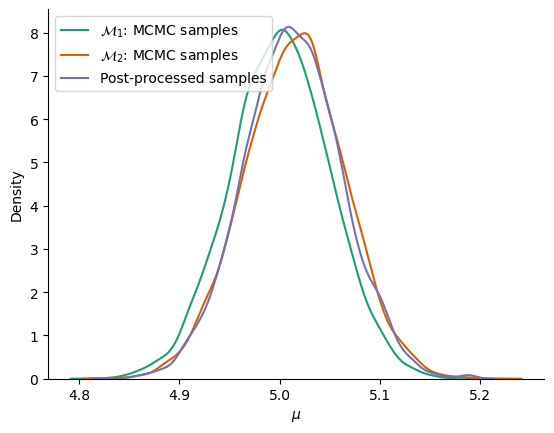

0.001974331836534282
0.012533531711037731


In [61]:
start_time = time.time()
log_weight_IR_2  = post_processing(f_n, f_0_2, samples_1, 'mu')
samples_IR_m, _ = multinomial_resampling_IS(samples_1, log_weight_IR_2)
print(time.time() - start_time)

density_plots(samples_1, samples_2_m, samples_IR_m, 'mu')
plt.legend(loc = 'upper left')
#plt.savefig('examples/gaussian/IR_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(samples_2_m, samples_IR_m))
print(stats.wasserstein_distance(samples_1, samples_IR_m))

In [165]:
np.savetxt("data/gaussian/samples_IR_m.txt", samples_IR_m, delimiter=",")

Annealed importance sampling

In [138]:
samples_pp, samples_ais_m, run_time, log_weight_variance = ais(origin_samples = samples_1, f_0 = f_0_2, f_n = f_n,
rv = 'mu', n_T = 5, n_beta = 5, rv_step_size = 0.05)

Run time: 19.7889142036438


In [166]:
np.savetxt("data/gaussian/samples_ais_m.txt", samples_ais_m, delimiter=",")

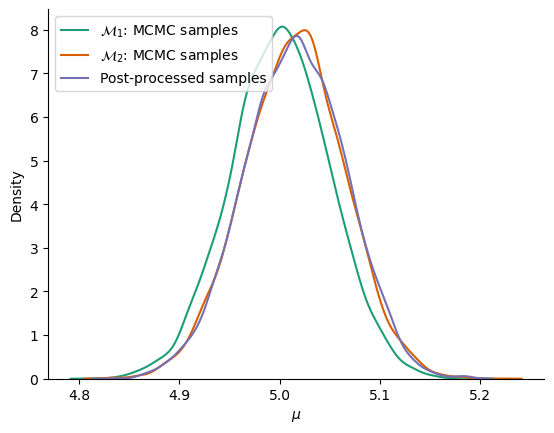

19.7889142036438
0.0009955184837221577
0.014611441183144275


In [140]:
density_plots(samples_1, samples_2_m, samples_ais_m, 'mu')
plt.legend(loc ='upper left')
#plt.savefig('examples/gaussian/AIS_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(run_time)
print(stats.wasserstein_distance(samples_2_m, samples_ais_m))
print(stats.wasserstein_distance(samples_1, samples_ais_m))

In [146]:
print('Truth')
print(np.mean(samples_2_m))
print(np.var(samples_2_m))
print('Importance reweighting')
print(np.mean(samples_IR_m))
print(np.var(samples_IR_m))
print('Annealed Importance sampling')
print(np.mean(samples_ais_m))
print(np.var(samples_ais_m))

Truth
5.01444543793839
0.002509611081679465
Importance reweighting
5.013185436901988
0.0023859743227421693
Annealed Importance sampling
5.0152627918559345
0.0025150996751850253


Warmstart MCMC 

Without initial conditions (short MCMC)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 35 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0.23728504330449351
0.012086827525805248


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.013,0.048,4.929,5.104,0.004,0.003,173.0,220.0,1.02


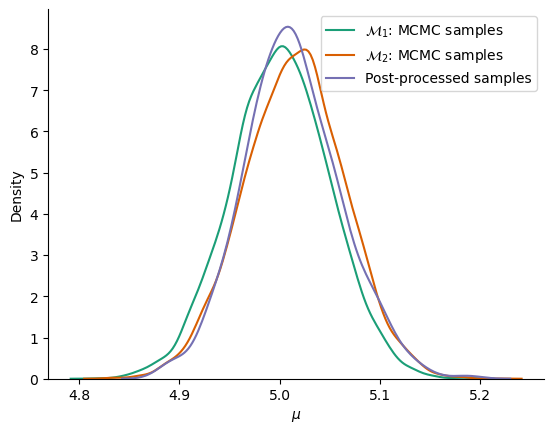

In [151]:
with model_2_m:
    idata_warmstart_m = pm.sample(chains = 4, draws = 100, return_inferencedata = True, tune = 50)

samples_2_ws_m = idata_warmstart_m.posterior.stack(draws=("chain", "draw"))['mu']
az.summary(idata_warmstart_m)

0.00402307291502127
0.012086827525805248


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.013,0.048,4.929,5.104,0.004,0.003,173.0,220.0,1.02


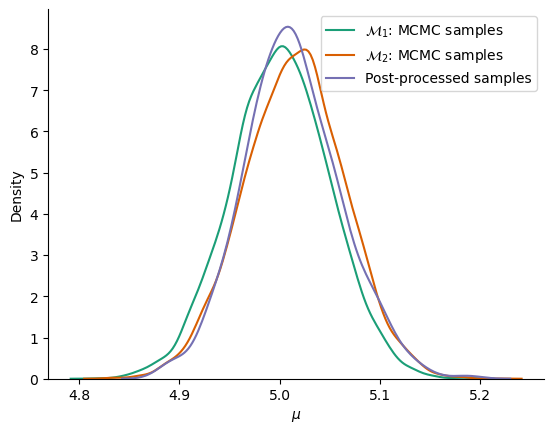

In [157]:
density_plots(samples_1, samples_2_m, samples_2_ws_m, 'mu')
print(stats.wasserstein_distance(samples_2_m, samples_2_ws_m))
print(stats.wasserstein_distance(samples_1, samples_2_ws_m))

With intial conditions (warm-start MCMC)

In [152]:
with model_2_m:
    idata_warmstart_init = pm.sample(chains = 4, draws = 100, return_inferencedata = True, initvals = init_dict, tune = 50)

samples_2_ws_m_init = idata_warmstart_init.posterior.stack(draws=("chain", "draw"))['mu']
az.summary(idata_warmstart_init)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 24 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.011,0.045,4.925,5.09,0.003,0.002,195.0,311.0,1.01


In [164]:
np.savetxt("data/gaussian/samples_2_ws_m_init.txt", samples_2_ws_m_init, delimiter=",")
np.savetxt("data/gaussian/samples_2_ws_m.txt", samples_2_ws_m, delimiter=",")

0.0047628867660081025
0.011031309452193027


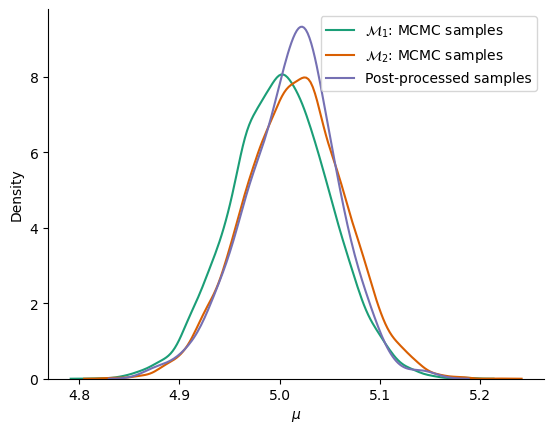

In [158]:
density_plots(samples_1, samples_2_m, samples_2_ws_m_init, 'mu')
print(stats.wasserstein_distance(samples_2_m, samples_2_ws_m_init))
print(stats.wasserstein_distance(samples_1, samples_2_ws_m_init))

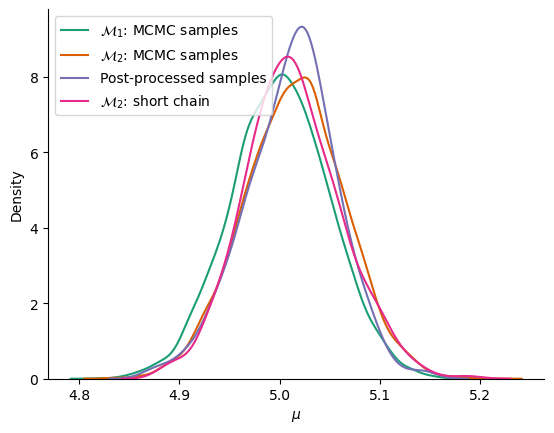

In [162]:
ax = plt.gca()
    # Make x label to greek symbol for latex
    # Create symbolic variable from string
x_label = Symbol('mu')
    
    # Plot density for model 1 and 2 samples
    # with the regenerated sample density 
sns.kdeplot(samples_1, label = r'$\mathcal{M}_1$: MCMC samples', ax = ax)
sns.kdeplot(samples_2_m, label = r'$\mathcal{M}_2$: MCMC samples', ax = ax)
sns.kdeplot(samples_2_ws_m_init, label = 'Post-processed samples', ax = ax)
sns.kdeplot(samples_2_ws_m, label = r'$\mathcal{M}_2$: short chain', ax = ax)

# Remove top and right lines
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)

# Latex to convert to latex string representation
ax.set_xlabel(f'${latex(x_label)}$')
ax.legend(loc = 'upper left')
plt.savefig('examples/gaussian/WS_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

In [160]:
print('Truth')
print(np.mean(samples_2_m))
print(np.var(samples_2_m))
print('Short MCMC')
print(np.mean(samples_2_ws_m))
print(np.var(samples_2_ws_m))
print('Warmstart MCMC')
print(np.mean(samples_2_ws_m_init))
print(np.var(samples_2_ws_m_init))

Truth
5.01444543793839
0.002509611081679465
Short MCMC
<xarray.DataArray 'mu' ()>
array(5.01273751)
<xarray.DataArray 'mu' ()>
array(0.00226899)
Warmstart MCMC
<xarray.DataArray 'mu' ()>
array(5.01137436)
<xarray.DataArray 'mu' ()>
array(0.00204897)


In [178]:
print('IS')
print(np.abs(np.mean(samples_2_m)-np.mean(samples_IR_m)))
print(np.abs(np.var(samples_2_m)-np.var(samples_IR_m)))
print('AIS')
print(np.abs(np.mean(samples_2_m)-np.mean(samples_ais_m)))
print(np.abs(np.var(samples_2_m)-np.var(samples_ais_m)))
print('Warmstart')
print(np.abs(np.mean(samples_2_m)-np.mean(samples_2_ws_m_init)))
print(np.abs(np.var(samples_2_m)-np.var(samples_2_ws_m_init)))
print('Short')
print(np.abs(np.mean(samples_2_m)-np.mean(samples_2_ws_m)))
print(np.abs(np.var(samples_2_m)-np.var(samples_2_ws_m)))

IS
0.001260001036401448
0.0001236367589372957
AIS
0.000817353917544672
5.4885935055603435e-06
Warmstart
<xarray.DataArray 'mu' ()>
array(0.00307108)
<xarray.DataArray 'mu' ()>
array(0.00046064)
Short
<xarray.DataArray 'mu' ()>
array(0.00170792)
<xarray.DataArray 'mu' ()>
array(0.00024062)


In [176]:
print('IS')
print(np.abs(np.mean(samples_2)-np.mean(samples_IR)))
print(np.abs(np.var(samples_2)-np.var(samples_IR)))
print('AIS')
print(np.abs(np.mean(samples_2)-np.mean(samples_ais)))
print(np.abs(np.var(samples_2)-np.var(samples_ais)))
print('Warmstart')
print(np.abs(np.mean(samples_2)-np.mean(samples_2_ws_init)))
print(np.abs(np.var(samples_2)-np.var(samples_2_ws_init)))
print('Short')
print(np.abs(np.mean(samples_2)-np.mean(samples_2_ws)))
print(np.abs(np.var(samples_2)-np.var(samples_2_ws)))

IS
0.0698660483092386
0.0021847456362739763
AIS
0.015556121761939323
0.00015863232784792732
Warmstart
<xarray.DataArray 'mu' ()>
array(0.00247793)
<xarray.DataArray 'mu' ()>
array(0.00011311)
Short
<xarray.DataArray 'mu' ()>
array(0.00619831)
<xarray.DataArray 'mu' ()>
array(0.00023123)


In [179]:
print(stats.wasserstein_distance(samples_2_m, samples_2_ws_m))
print(stats.wasserstein_distance(samples_2_m, samples_2_ws_m_init))

print(stats.wasserstein_distance(samples_2, samples_2_ws))
print(stats.wasserstein_distance(samples_2, samples_2_ws_init))

0.00402307291502127
0.0047628867660081025
0.006346805922202289
0.0033510742178952772
